# White Box Model Exploration

The idea of this section is to explore how good the WB model is, and to decide whether it is possible to make it more accurate

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import json
from config import DATA_DIR, TFO_PARAMETERS_FILE
from scipy.optimize import least_squares

alldf = pd.read_csv('data/final_merged_data_with_wb_pred.csv')

exclude_ids = [76075, 76632]

alldf = alldf[~alldf['equipmentId'].isin(exclude_ids)]

alldf

,Unnamed: 0.1,Unnamed: 0,equipmentId,nominalLoad,locationId,coolingType,manufactureYear,commissioningDate,enclosure,heatRunTest_noLoadLosses,...,heatRunTest_h,heatRunTest_gradient,dateTime,load,hotspotTemperature,temperature,windSpeed,relativeHumidityPercentage,city,wb_pred
0,0,0,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-04-30 23:00:00,10130.00,40.50,12.26,2.05,70.96,Wilsele,NaN
1,1,4,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 00:00:00,9160.97,38.61,11.73,1.60,74.35,Wilsele,25.356879
2,2,8,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 01:00:00,12049.23,38.77,11.35,1.39,77.63,Wilsele,28.064633
3,3,12,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 02:00:00,11077.78,38.67,10.80,1.13,80.86,Wilsele,26.411574
4,4,16,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 03:00:00,11093.11,37.92,10.62,1.00,82.36,Wilsele,26.248490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249283,249283,997132,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 18:00:00,15281.92,47.47,3.87,7.27,94.12,Anderlecht,41.547430
249284,249284,997136,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 19:00:00,14497.30,48.05,4.15,7.33,93.61,Anderlecht,39.675514
249285,249285,997140,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 20:00:00,13493.01,47.65,4.28,7.48,92.85,Anderlecht,37.123920
249286,249286,997144,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 21:00:00,12719.02,46.36,4.61,8.14,93.20,Anderlecht,35.446373


In [22]:
# Count of rows with hotspotTemperature 0
(alldf['hotspotTemperature'] == 0).sum()

np.int64(0)

In [133]:
METRIC_COLUMNS = ['MAE', 'RMSE', 'Bias', 'R2', 'NRMSE%_IQR', 'P95_abs_err', 'Max_abs_err']
K_BINS = [0, 0.5, 0.9, 1.1, np.inf]
K_LABELS = ["<0.5", "0.5–0.9", "0.9–1.1", ">1.1"]
# add to metric_columns the by-K metrics
for k in K_LABELS:
    for metric in ['n', 'MAE', 'RMSE', 'Bias']:
        METRIC_COLUMNS.append(f'K_{k}_{metric}')

def divide_by_k_df_into_columns(byK):
    # Convert byK to individual columns
    byK = byK.to_dict(orient='index')
    keys = list(byK.keys())
    values = list(byK.values())
    for k, v in zip(keys, values):
        for metric in ['n', 'MAE', 'RMSE', 'Bias']:
            byK[f'K_{k}_{metric}'] = v[metric]
        del byK[k]
    return byK

def merge_by_k_columns_into_df(metrics_dict, labels=None, index_name='K_bin'):
    byK = {k: v for k, v in metrics_dict.items() if k.startswith('K_')}
    if not byK:
        return pd.DataFrame(columns=['n','MAE','RMSE','Bias'])

    # rebuild nested dict: {k_bin: {metric: value}}
    nested = {}
    for key, val in byK.items():
        _, k_bin, metric = key.split('_', 2)  # "K_<bin>_<metric>"
        nested.setdefault(k_bin, {})[metric] = val

    df = pd.DataFrame.from_dict(nested, orient='index')[['n','MAE','RMSE','Bias']]

    # keep your label order if provided
    if labels is not None:
        df = df.reindex(labels)

    # restore the index name so print shows "K_bin" above the bins
    df.index.name = index_name
    return df
    

def get_metrics(d, y_true_vals, y_pred_vals, load_col='load', nominal_load_col='nominalLoad'):
    # errors as an index-aligned Series
    err = pd.Series(y_pred_vals - y_true_vals, index=d.index, dtype=float)
    d = d.copy()
    d['err'] = err
    d['abs_err'] = err.abs()
    d['sq_err'] = err**2

    mae  = d['abs_err'].mean()
    rmse = np.sqrt(d['sq_err'].mean())
    mbe  = d['err'].mean()

    # Robust NRMSE (% of IQR)
    q75, q25 = np.percentile(y_true_vals, 75), np.percentile(y_true_vals, 25)
    iqr = q75 - q25 if (q75 - q25) > 0 else (np.max(y_true_vals) - np.min(y_true_vals))
    nrmse_pct = 100 * rmse / iqr if iqr > 0 else np.nan
    r2 = 1 - d['sq_err'].sum() / np.sum((y_true_vals - np.mean(y_true_vals))**2)

    # Bin by K and aggregate **per bin**
    d['K_bin'] = pd.cut(
        d[load_col] / (d[nominal_load_col] * 1000),
        bins=K_BINS, labels=K_LABELS, include_lowest=True
    )

    byK = d.groupby('K_bin', observed=False).agg(
        n=('err', 'size'),
        MAE=('abs_err', 'mean'),
        RMSE_mean_sq=('sq_err', 'mean'),
        Bias=('err', 'mean'),
    )
    byK['RMSE'] = np.sqrt(byK['RMSE_mean_sq'])
    byK = byK[['n','MAE','RMSE','Bias']]

    # (optional) keep the header "K_bin" when printing
    byK.index.name = 'K_bin'

    # flatten to dict if you still need the K_* columns
    byK_flat = divide_by_k_df_into_columns(byK)

    metrics_dict = {
        'MAE': mae, 'RMSE': rmse, 'Bias': mbe,
        'NRMSE%_IQR': nrmse_pct, 'R2': r2,
        'P95_abs_err': d['abs_err'].quantile(0.95),
        'Max_abs_err': d['abs_err'].max(),
    }
    metrics_dict.update(byK_flat)
    return metrics_dict

def eval_wb(df, y_true='hotspotTemperature', y_pred='wb_pred', load_col='load', nominal_load_col='nominalLoad', bias_correction= 0):
    d = df[[y_true, y_pred, load_col, nominal_load_col]].dropna().copy()
    y_pred_vals = d[y_pred] + bias_correction
    y_true_vals = d[y_true]
    metrics_dict = get_metrics(d, y_true_vals, y_pred_vals, load_col, nominal_load_col)
    return metrics_dict

def print_metrics_cols(results, metric_cols = None):
    if metric_cols is None:
        metric_cols = METRIC_COLUMNS

    if isinstance(results, dict):
        results = pd.DataFrame([results])

    mean_vals = results[metric_cols].mean(numeric_only=True)
    # Print those that dont start with 'K'
    for col_fit in metric_cols:
        if not col_fit.startswith('K'):
            print(f"{col_fit}: {mean_vals[col_fit]:.3f}")
    # Print K-bin metrics separately
    kbin_cols = [c for c in metric_cols if c.startswith('K')]
    if kbin_cols:
        kbin_dict = {}
        for col_fit in kbin_cols:
            col_name = '_'.join(col_fit.split('_')[0:3])
            kbin_dict[col_name] = mean_vals[col_fit]
        kbin_df = merge_by_k_columns_into_df(kbin_dict)
        print(kbin_df)

# Example usage:
# results = eval_wb(df)  # df must have temp_meas, wb_pred, K
# print(results)


In [94]:
eval_results = eval_wb(alldf)
eval_results

                n       MAE     RMSE      Bias
K_bin                                         
<0.5     183404.0  7.545724  9.10136 -7.157948
0.5–0.9   23173.0  7.545724  9.10136 -7.157948
0.9–1.1     407.0  7.545724  9.10136 -7.157948
>1.1          0.0  7.545724  9.10136 -7.157948
                n       MAE     RMSE      Bias
K_bin                                         
<0.5     183404.0  7.545724  9.10136 -7.157948
0.5–0.9   23173.0  7.545724  9.10136 -7.157948
0.9–1.1     407.0  7.545724  9.10136 -7.157948
>1.1          0.0  7.545724  9.10136 -7.157948


C:\Users\Mario\AppData\Local\Temp\ipykernel_30352\2225609534.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_30352\2225609534.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.545723646063696),
 'RMSE': np.float64(9.101360473733653),
 'Bias': np.float64(-7.1579483211514985),
 'NRMSE%_IQR': np.float64(60.91941414815028),
 'R2': np.float64(0.43103795374704923),
 'P95_abs_err': np.float64(16.950794539915538),
 'Max_abs_err': np.float64(102.62035619691665),
 'K_<0.5_n': 183404.0,
 'K_<0.5_MAE': 7.545723646063696,
 'K_<0.5_RMSE': 9.101360473733653,
 'K_<0.5_Bias': -7.1579483211514985,
 'K_0.5–0.9_n': 23173.0,
 'K_0.5–0.9_MAE': 7.545723646063696,
 'K_0.5–0.9_RMSE': 9.101360473733653,
 'K_0.5–0.9_Bias': -7.1579483211514985,
 'K_0.9–1.1_n': 407.0,
 'K_0.9–1.1_MAE': 7.545723646063696,
 'K_0.9–1.1_RMSE': 9.101360473733653,
 'K_0.9–1.1_Bias': -7.1579483211514985,
 'K_>1.1_n': 0.0,
 'K_>1.1_MAE': 7.545723646063696,
 'K_>1.1_RMSE': 9.101360473733653,
 'K_>1.1_Bias': -7.1579483211514985}

In [24]:
eval_results = eval_wb(alldf, bias_correction=7.16)
eval_results

C:\Users\Mario\AppData\Local\Temp\ipykernel_30352\1921389797.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_30352\1921389797.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(4.270832961638797),
 'RMSE': np.float64(5.621258089960983),
 'Bias': np.float64(0.002051678848501381),
 'NRMSE%_IQR': np.float64(37.62555615770403),
 'R2': np.float64(0.7829610314480786),
 'P95_abs_err': np.float64(11.165486661262817),
 'Max_abs_err': np.float64(109.78035619691664),
 'by_K_bin':                 n       MAE      RMSE      Bias
 K_bin                                          
 <0.5     183404.0  4.181247  5.466320  0.205927
 0.5–0.9   23173.0  5.435921  7.041778 -1.455603
 0.9–1.1     407.0  3.632048  4.724047 -1.048187
 >1.1          0.0       NaN       NaN       NaN}

## Problems with the data

- Sometimes ambient T is missing
- Sometimes hotspot T goes to negative values or shoots up (e.g. 5030256)
![image](figures/notebooks/hotspot_t_shoots_up_or_down.png)
- Sometimes, when there is no load, the transformer has a voltage and sometimes it doesn't. In this picture it's clear when the transformer is energized
![image](figures/notebooks/energized_vs_non_energized_without_load.png)

# Possible Improvements

- $R = \frac{P_{cu}}{(1-s) P_{no\_loss}}$, with $s \approx 0.1$

- $ K = \frac{S_{load}}{S_{rated}} = \frac{P}{PF \dot S_{rated}} $ where PF is the Power Factor as $ PF = cos(\phi) $ and $\phi$ is the phase shift between current and voltage. $ PF \approx 0.9$

- When load is 0, $ T_{wb\_pred} \neq T_{amb} $ Edit: this one is not a problem. With no load there's still voltage thus Eddy currents and temperature increase.

In [ ]:
def white_box_model(theta_a, delta_top_oil, delta_hotspot, x_param, y_param, R=0.1, K=0.05):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + K ** y_param * (delta_hotspot - delta_top_oil) + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_deltaHotspot'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [67]:
# Here it uses the gradient column instead of delta_hotspot - delta_top_oil

def white_box_model(theta_a, delta_top_oil, gradient, x_param, y_param, R=0.1, K=0.05):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + K ** y_param * gradient + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_gradient'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [ ]:
results = wb_preds_for_df(alldf)
results = eval_wb(results)
results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.898856894776845),
 'RMSE': np.float64(9.460494431035835),
 'Bias': np.float64(-7.567956896965914),
 'NRMSE%_IQR': np.float64(61.47169870718541),
 'R2': np.float64(0.40492325355711667),
 'P95_abs_err': np.float64(17.477422137299286),
 'Max_abs_err': np.float64(101.77319554694921),
 'by_K_bin':                 n        MAE       RMSE      Bias
 K_bin                                            
 <0.5     183419.0   7.606125   9.119759 -7.296244
 0.5–0.9   23173.0  10.179606  11.794978 -9.679414
 0.9–1.1     407.0   9.964445  10.835804 -9.800322
 >1.1          0.0        NaN        NaN       NaN}

In [70]:
# Here i am including h also

def white_box_model(theta_a, delta_top_oil, gradient, x_param, y_param, h, R, K):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + h * K ** y_param * gradient + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_gradient'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['heatRunTest_h'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [ ]:
results = wb_preds_for_df(alldf)
results = eval_wb(results)
results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.544876263386686),
 'RMSE': np.float64(9.111367094685729),
 'Bias': np.float64(-7.139613037629815),
 'NRMSE%_IQR': np.float64(59.20316500770454),
 'R2': np.float64(0.44803390672794474),
 'P95_abs_err': np.float64(16.97595508225528),
 'Max_abs_err': np.float64(102.64456078691572),
 'by_K_bin':                 n       MAE       RMSE      Bias
 K_bin                                           
 <0.5     183419.0  7.308531   8.840195 -6.952039
 0.5–0.9   23173.0  9.399365  11.020755 -8.605957
 0.9–1.1     407.0  8.468951   9.391011 -8.183873
 >1.1          0.0       NaN        NaN       NaN}

In [72]:
# Lastly I am using h but also (delta_hotspot - delta_top_oil)

def white_box_model(theta_a, delta_top_oil, delta_hotspot, x_param, y_param, h, R, K):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + h * K ** y_param * (delta_hotspot - delta_top_oil) + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_deltaHotspot'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['heatRunTest_h'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [ ]:
results = wb_preds_for_df(alldf)
results = eval_wb(results)
results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.156129355842767),
 'RMSE': np.float64(8.737205320892862),
 'Bias': np.float64(-6.62184851010227),
 'NRMSE%_IQR': np.float64(56.77196439826421),
 'R2': np.float64(0.49243648744657387),
 'P95_abs_err': np.float64(16.47001790777963),
 'Max_abs_err': np.float64(103.5764375018799),
 'by_K_bin':                 n       MAE       RMSE      Bias
 K_bin                                           
 <0.5     183419.0  6.968196   8.527692 -6.529281
 0.5–0.9   23173.0  8.649082  10.257658 -7.358758
 0.9–1.1     407.0  6.847515   7.881779 -6.381571
 >1.1          0.0       NaN        NaN       NaN}

**Result**

The best results are achieved (when using the parameters from the dataset) using hotspot-oil and h simultaneously.

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=1 -> MAE=5.66, RMSE=7.32, Bias=-4.50, R2=0.644
s=-0.6, pf=0.95 -> MAE=5.24, RMSE=6.84, Bias=-3.75, R2=0.689


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=0.9 -> MAE=4.91, RMSE=6.44, Bias=-2.89, R2=0.724
s=-0.6, pf=0.85 -> MAE=4.75, RMSE=6.24, Bias=-1.90, R2=0.741


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=0.8 -> MAE=4.82, RMSE=6.36, Bias=-0.74, R2=0.731
s=-0.6, pf=0.75 -> MAE=5.19, RMSE=6.97, Bias=0.62, R2=0.677


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=0.7 -> MAE=5.91, RMSE=8.18, Bias=2.23, R2=0.555
s=-0.8, pf=1 -> MAE=5.32, RMSE=6.97, Bias=-3.86, R2=0.677


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.8, pf=0.95 -> MAE=4.96, RMSE=6.53, Bias=-3.13, R2=0.717
s=-0.8, pf=0.9 -> MAE=4.69, RMSE=6.19, Bias=-2.28, R2=0.745


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.8, pf=0.85 -> MAE=4.60, RMSE=6.06, Bias=-1.30, R2=0.756
s=-0.8, pf=0.8 -> MAE=4.74, RMSE=6.27, Bias=-0.17, R2=0.739


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-0.8, pf=0.75 -> MAE=5.17, RMSE=6.96, Bias=1.17, R2=0.678
s=-0.8, pf=0.7 -> MAE=5.95, RMSE=8.22, Bias=2.76, R2=0.550
s=-1, pf=1 -> MAE=5.05, RMSE=6.68, Bias=-3.26, R2=0.703


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1, pf=0.95 -> MAE=4.75, RMSE=6.28, Bias=-2.53, R2=0.738
s=-1, pf=0.9 -> MAE=4.54, RMSE=6.00, Bias=-1.70, R2=0.760
s=-1, pf=0.85 -> MAE=4.50, RMSE=5.94, Bias=-0.74, R2=0.765


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1, pf=0.8 -> MAE=4.71, RMSE=6.23, Bias=0.38, R2=0.742
s=-1, pf=0.75 -> MAE=5.20, RMSE=6.99, Bias=1.70, R2=0.675
s=-1, pf=0.7 -> MAE=6.03, RMSE=8.31, Bias=3.26, R2=0.541


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.2, pf=1 -> MAE=4.85, RMSE=6.44, Bias=-2.67, R2=0.724
s=-1.2, pf=0.95 -> MAE=4.59, RMSE=6.09, Bias=-1.96, R2=0.753


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.2, pf=0.9 -> MAE=4.44, RMSE=5.87, Bias=-1.14, R2=0.771
s=-1.2, pf=0.85 -> MAE=4.46, RMSE=5.88, Bias=-0.20, R2=0.770


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.2, pf=0.8 -> MAE=4.72, RMSE=6.24, Bias=0.91, R2=0.741
s=-1.2, pf=0.75 -> MAE=5.27, RMSE=7.06, Bias=2.20, R2=0.668
s=-1.2, pf=0.7 -> MAE=6.14, RMSE=8.42, Bias=3.75, R2=0.529


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.4, pf=1 -> MAE=4.71, RMSE=6.26, Bias=-2.12, R2=0.740
s=-1.4, pf=0.95 -> MAE=4.50, RMSE=5.96, Bias=-1.41, R2=0.764


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.4, pf=0.9 -> MAE=4.40, RMSE=5.80, Bias=-0.61, R2=0.776
s=-1.4, pf=0.85 -> MAE=4.47, RMSE=5.88, Bias=0.32, R2=0.770


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.4, pf=0.8 -> MAE=4.78, RMSE=6.30, Bias=1.41, R2=0.736
s=-1.4, pf=0.75 -> MAE=5.37, RMSE=7.17, Bias=2.69, R2=0.658
s=-1.4, pf=0.7 -> MAE=6.29, RMSE=8.55, Bias=4.21, R2=0.514


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.6, pf=1 -> MAE=4.62, RMSE=6.13, Bias=-1.58, R2=0.751
s=-1.6, pf=0.95 -> MAE=4.45, RMSE=5.88, Bias=-0.89, R2=0.770
s=-1.6, pf=0.9 -> MAE=4.40, RMSE=5.78, Bias=-0.10, R2=0.778


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.6, pf=0.85 -> MAE=4.52, RMSE=5.92, Bias=0.82, R2=0.767
s=-1.6, pf=0.8 -> MAE=4.87, RMSE=6.40, Bias=1.90, R2=0.728
s=-1.6, pf=0.75 -> MAE=5.50, RMSE=7.31, Bias=3.16, R2=0.645


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.6, pf=0.7 -> MAE=6.46, RMSE=8.71, Bias=4.66, R2=0.496
s=-1.8, pf=1 -> MAE=4.57, RMSE=6.04, Bias=-1.07, R2=0.757


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.8, pf=0.95 -> MAE=4.45, RMSE=5.84, Bias=-0.39, R2=0.773
s=-1.8, pf=0.9 -> MAE=4.43, RMSE=5.80, Bias=0.40, R2=0.776
s=-1.8, pf=0.85 -> MAE=4.60, RMSE=6.00, Bias=1.30, R2=0.761


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.8, pf=0.8 -> MAE=5.00, RMSE=6.53, Bias=2.36, R2=0.717
s=-1.8, pf=0.75 -> MAE=5.66, RMSE=7.47, Bias=3.61, R2=0.629


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.8, pf=0.7 -> MAE=6.65, RMSE=8.88, Bias=5.09, R2=0.476
s=-2, pf=1 -> MAE=4.57, RMSE=6.00, Bias=-0.58, R2=0.761
s=-2, pf=0.95 -> MAE=4.48, RMSE=5.85, Bias=0.10, R2=0.772


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-2, pf=0.9 -> MAE=4.51, RMSE=5.86, Bias=0.87, R2=0.771
s=-2, pf=0.85 -> MAE=4.71, RMSE=6.11, Bias=1.77, R2=0.752
s=-2, pf=0.8 -> MAE=5.15, RMSE=6.68, Bias=2.81, R2=0.703


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-2, pf=0.75 -> MAE=5.85, RMSE=7.64, Bias=4.04, R2=0.612
s=-2, pf=0.7 -> MAE=6.86, RMSE=9.06, Bias=5.51, R2=0.454

Saved grid results to wb_full_eval_grid.csv


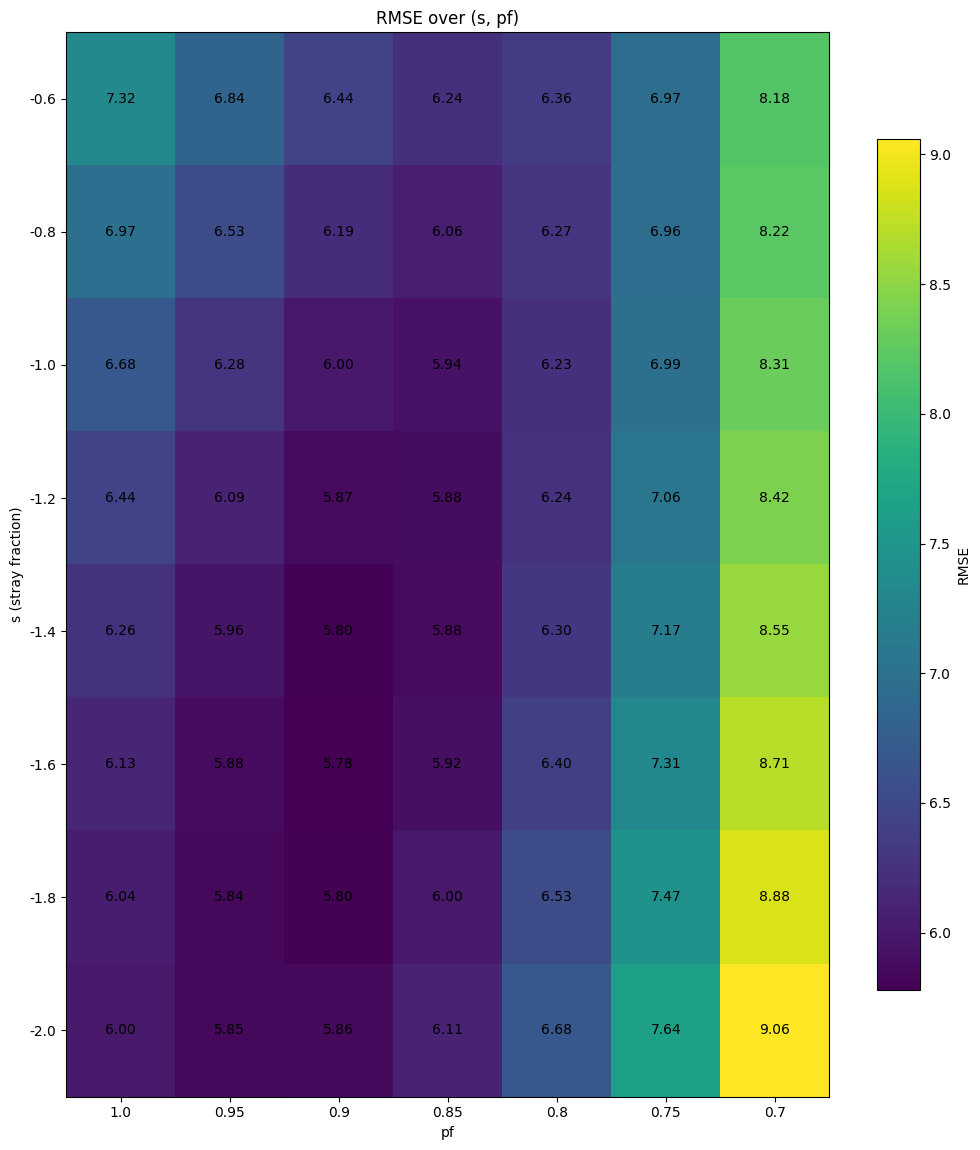

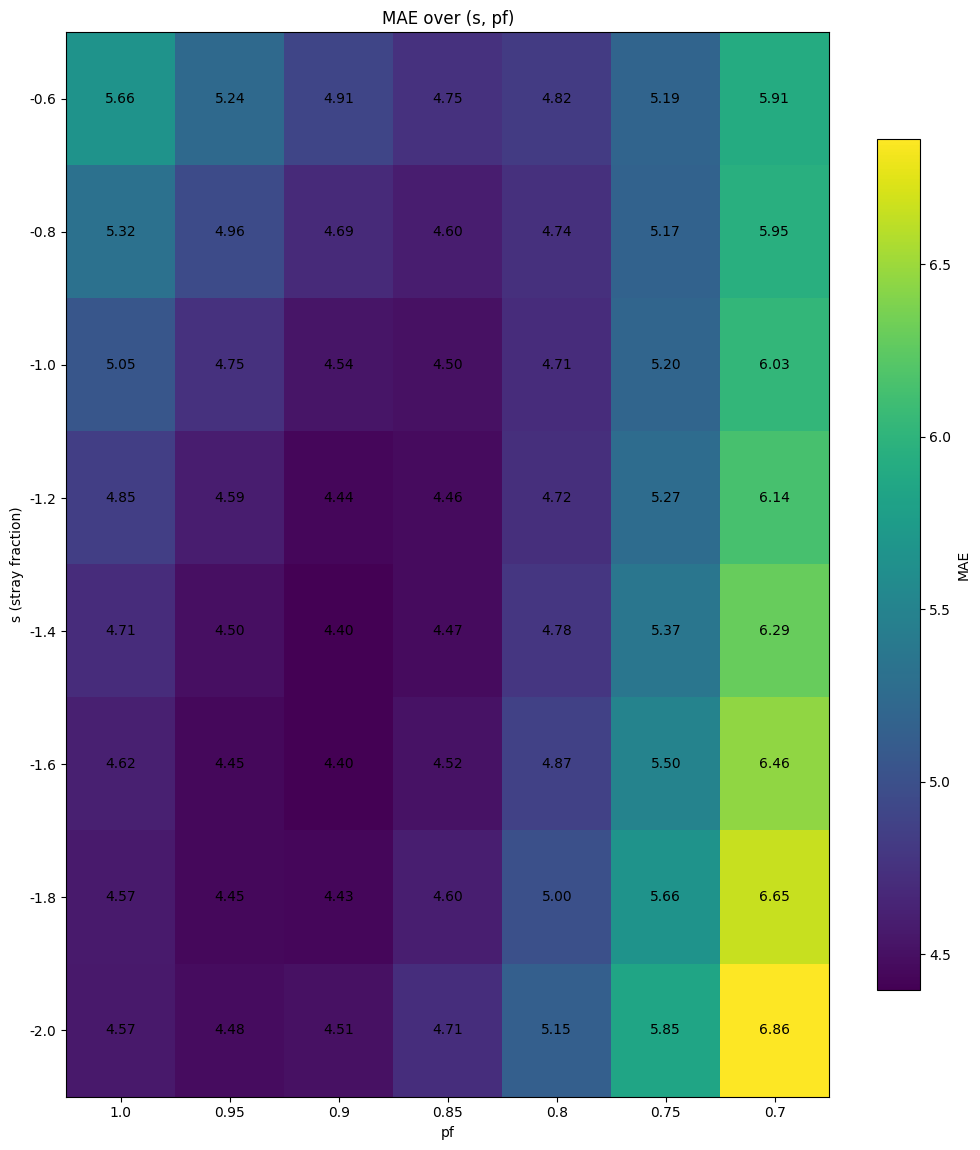

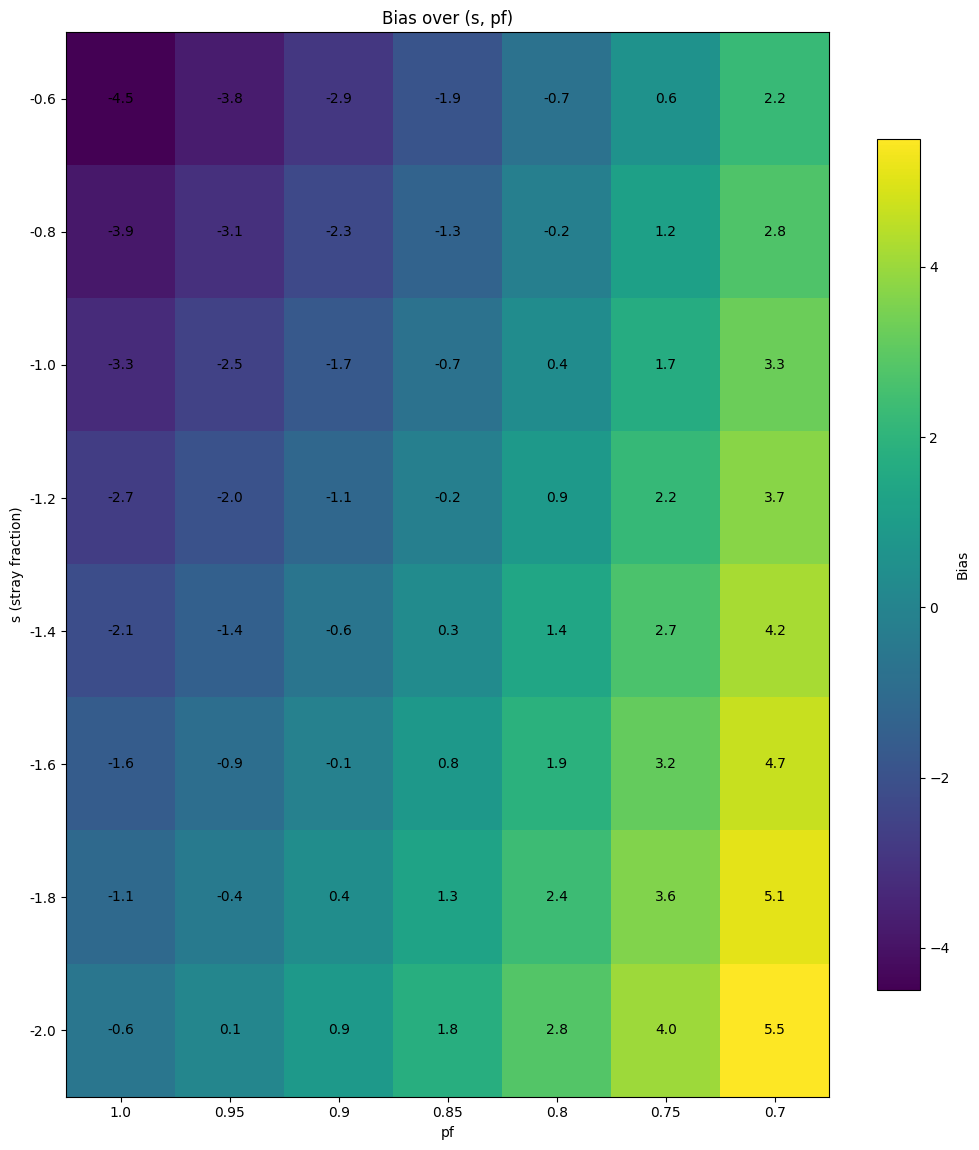

In [74]:
# ---- 1) Sweep all (s, pf) pairs and collect results ----
def run_grid(alldf, s_values, pf_values, save_path="wb_eval_grid.csv"):
    """
    For each (s, pf), calls:
       df_with_preds = wb_preds_for_df(alldf, s=s, pf=pf)
       eval_results  = eval_wb(df_with_preds)
    Returns a DataFrame with one row per (s, pf) containing top-level metrics.
    Also saves to CSV if save_path is not None.
    """
    rows = []
    for s, pf in product(s_values, pf_values):  # cartesian product
        dfp = wb_preds_for_df(alldf.copy(), s=s, pf=pf)  # use a copy just in case
        er  = eval_wb(dfp)

        # keep only top-level scalar metrics; stash the K-bin table as JSON (optional)
        byK = er.pop('by_K_bin', None)
        row = {'s': float(s), 'pf': float(pf)}
        row.update({k: (float(v) if np.isscalar(v) else v) for k, v in er.items()})
        if byK is not None:
            try:
                row['by_K_bin_json'] = json.dumps(byK.round(3).to_dict())
            except Exception:
                row['by_K_bin_json'] = None
        rows.append(row)

        print(f"s={s}, pf={pf} -> MAE={row['MAE']:.2f}, RMSE={row['RMSE']:.2f}, Bias={row['Bias']:.2f}, R2={row['R2']:.3f}")

    results = pd.DataFrame(rows)

    # normalize the column name for NRMSE if your eval returns 'NRMSE%_IQR'
    if 'NRMSE%_IQR' in results.columns:
        results = results.rename(columns={'NRMSE%_IQR': 'NRMSE_IQR_pct'})

    # optional: enforce the exact display order
    results['s']  = pd.Categorical(results['s'],  categories=s_values,  ordered=True)
    results['pf'] = pd.Categorical(results['pf'], categories=pf_values, ordered=True)

    if save_path:
        results.to_csv(save_path, index=False)
        print(f"\nSaved grid results to {save_path}")

    return results


# ---- 2) Plot a metric as an s×pf matrix (heatmap with value labels) ----
def plot_metric_grid(results_df, metric='RMSE', title=None, fmt="{:.2f}"):
    """
    Creates an s (rows) × pf (cols) matrix of the chosen metric and plots it.
    """
    if metric not in results_df.columns:
        raise KeyError(f"Metric '{metric}' not found in results_df columns: {list(results_df.columns)}")

    # ensure desired ordering (uses Categoricals if set above)
    df = results_df.copy()
    if not isinstance(df['s'].dtype, pd.CategoricalDtype):
        df = df.sort_values(['s', 'pf'])
    matrix = df.pivot(index='s', columns='pf', values=metric)

    fig, ax = plt.subplots(figsize=(1.2*matrix.shape[1]+2, 1.2*matrix.shape[0]+2))
    im = ax.imshow(matrix.values, aspect='auto')  # default colormap is fine

    # axes & labels
    ax.set_xticks(range(matrix.shape[1]), labels=[str(c) for c in matrix.columns])
    ax.set_yticks(range(matrix.shape[0]), labels=[str(r) for r in matrix.index])
    ax.set_xlabel("pf")
    ax.set_ylabel("s (stray fraction)")
    ax.set_title(title or f"{metric} over (s, pf)")

    # annotate cells
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix.values[i, j]
            if pd.notna(val):
                ax.text(j, i, fmt.format(val), ha='center', va='center')

    fig.colorbar(im, ax=ax, shrink=0.8, label=metric)
    plt.tight_layout()
    plt.show()


# ---- 3) Example usage ----
s_values = [-0.6, -0.8, -1, -1.2, -1.4, -1.6, -1.8, -2]
pf_values = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
results_df = run_grid(alldf, s_values, pf_values, save_path="wb_full_eval_grid.csv")
plot_metric_grid(results_df, metric="RMSE")        # heatmap of RMSE
plot_metric_grid(results_df, metric="MAE")         # or MAE, Bias, R2, NRMSE_IQR_pct, etc.
plot_metric_grid(results_df, metric="Bias", fmt="{:.1f}")        # heatmap of Bias

**Best Results** (the values were computed using hotspot - oil and no h. Best results for this case, not in general)

s = -1.4

Pf = 0.85


This makes no sense, because *s* should be positive. Also, when using these values, even though global values look good, bin values show that the model underpredicts for lower loads and overpredicts for big loads. This probably highlights a wrong value of the variables empirically measured.

In [75]:
print("Best results (lowest RMSE):")
best_results = results_df.loc[results_df['MAE'].idxmin()]
print(best_results)
print(best_results['by_K_bin_json'])

Best results (lowest RMSE):
s                                                             -1.4
pf                                                             0.9
MAE                                                       4.395323
RMSE                                                      5.800598
Bias                                                     -0.608246
NRMSE_IQR_pct                                            37.690692
R2                                                        0.776287
P95_abs_err                                              11.659373
Max_abs_err                                             111.152118
by_K_bin_json    {"n": {"<0.5": 183419.0, "0.5\u20130.9": 23173...
Name: 30, dtype: object
{"n": {"<0.5": 183419.0, "0.5\u20130.9": 23173.0, "0.9\u20131.1": 407.0, ">1.1": 0.0}, "MAE": {"<0.5": 4.257, "0.5\u20130.9": 5.497, "0.9\u20131.1": 3.974, ">1.1": NaN}, "RMSE": {"<0.5": 5.588, "0.5\u20130.9": 7.277, "0.9\u20131.1": 5.089, ">1.1": NaN}, "Bias": {"<0.5": -0.69, 

## Model Fit to Each Transformer

There are two main reasons to get the parameters again:

- Tuning just *s* and *PF* made the model lose physical meaning ($s < 0$).
- There is no reason to assume that the transformer rating values remained constant throughout the years.

In [ ]:
keys = ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']
default_values = {
    's': 0.0,
    'pf': 1,
    'ambient_bias': 0.0,
}

# ---- WB model core (vectorized over a dataframe 'd') ----
def wb_predict(d, params):
    """
    d must have columns:
      ambient (°C), temp_meas (°C), P_kW (kW), rated_kVA (kVA),
      Pcu_ref_W (W at reference temp), P0_W (W at rated V)
    params: dict with keys ['s','pf','ambient_bias','deltaTopOil','deltaHotspot','x','y','h']
    Returns vector of predicted absolute HS temperature (°C).
    """
    s   = params['s']
    pf  = params['pf']
    amb = params['ambient_bias']
    dTO = params['heatRunTest_deltaTopOil']
    dH  = params['heatRunTest_deltaHotspot']
    x   = params['heatRunTest_x']
    y   = params['heatRunTest_y']
    h   = params['heatRunTest_h']

    # R and K
    Pload_ref = d['heatRunTest_copperLosses'] / (1.0 - s)  # W
    R = Pload_ref / d['heatRunTest_noLoadLosses']               # dimensionless
    K = (d['load'] / (pf * d['nominalLoad'] * 1000)) # per-unit (assumes P in kW, S_rated in MVA)

    # Clamp K to sane range to avoid exploding residuals during early iterations
    K = np.clip(K.values, 0, 2.5)

    # R may vary by timestamp if Pcu_ref_W or P0_W are columns; if they are scalars, broadcast works.
    R = np.asarray(R)

    top_oil_rise = dTO * np.power((1.0 + R * (K**2)) / (1.0 + R), x)
    hs_rise      = h * (K**y) * (dH - dTO)

    return d['temperature'].values + top_oil_rise + hs_rise #+ amb

# ---- residuals for robust least squares ----
def residuals_vec(theta, d, priors=None, prior_weight=0.0):
    # unpack vector -> params dict
    p = {
        's':            theta[0],
        'pf':           theta[1],
        'ambient_bias': theta[2],
        'heatRunTest_deltaTopOil':  theta[3],
        'heatRunTest_deltaHotspot': theta[4],
        'heatRunTest_x':            theta[5],
        'heatRunTest_y':            theta[6],
        'heatRunTest_h':            theta[7],
    }
    pred = wb_predict(d, p)
    res  = pred - d['hotspotTemperature'].values

    # optional light regularization toward priors to help identifiability (pf,s,x,y)
    if priors and prior_weight > 0:
        reg = []
        for k, mu in priors.items():
            reg.append(prior_weight * (p[k] - mu))
        res = np.concatenate([res, np.array(reg, dtype=float)])

    return res

# ---- get preds and metrics from model params ----
def get_preds_and_metrics(d, params_hat):

        # predictions & quick metrics
        pred = wb_predict(d, params_hat)
        err  = pred - d['hotspotTemperature'].values
        mae  = float(np.mean(np.abs(err)))
        rmse = float(np.sqrt(np.mean(err**2)))
        bias = float(np.mean(err))
        r2   = float(1 - np.sum(err**2) / np.sum((d['hotspotTemperature'] - d['hotspotTemperature'].mean())**2))
        return {'MAE': mae, 'RMSE': rmse, 'Bias': bias, 'R2': r2}, pred

# ---- fit one transformer (grouped df) ----
def fit_transformer(df_equipment,
                    init=None,
                    bounds=None,
                    priors=None,
                    prior_weight=0.0):
    # defaults
    if init is None:
        init = dict(
            s=0.10, pf=0.95, ambient_bias=0.0,
            heatRunTest_deltaTopOil=50.0, heatRunTest_deltaHotspot=63.0,  # rough starting rises (°C)
            heatRunTest_x=0.8, heatRunTest_y=1.5, heatRunTest_h=1.0
        )

    if bounds is None:
        bounds = dict(
            s=(0.0, 0.25),
            pf=(0.80, 1.00),
            ambient_bias=(-2.0, 2.0),
            heatRunTest_deltaTopOil=(5.0, 80.0),
            heatRunTest_deltaHotspot=(10.0, 120.0),
            heatRunTest_x=(0.6, 1.2),
            heatRunTest_y=(0.8, 2.2),
            heatRunTest_h=(0.7, 1.5),
        )

    # pack into vectors
    x0 = np.array([init[k] for k in ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']], dtype=float)
    lb = np.array([bounds[k][0] for k in ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']], dtype=float)
    ub = np.array([bounds[k][1] for k in ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']], dtype=float)

    # drop NAs and obviously bad rows
    d = df_equipment[['temperature','hotspotTemperature','load','nominalLoad','heatRunTest_copperLosses','heatRunTest_noLoadLosses']].dropna().copy()
    # optional: restrict to a time window here if needed

    # robust least squares
    sol = least_squares(
        residuals_vec, x0,
        args=(d, priors, prior_weight),
        bounds=(lb, ub),
        loss='soft_l1', f_scale=5.0,  # robust to outliers
        max_nfev=200
    )

    keys = ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']
    params_hat = {k: float(v) for k, v in zip(keys, sol.x)}
    metrics, pred = get_preds_and_metrics(d, params_hat)

    return params_hat, metrics, pred

# ---- batch fit across transformers ----
def fit_all_transformers(df,
                         id_col='equipmentId',
                         priors=None,
                         prior_weight=0.0, og_comparison=False):
    results = []
    preds   = []

    for eid, g in df.groupby(id_col):
        try:
            p_hat, metrics, pred = fit_transformer(g, priors=priors, prior_weight=prior_weight)
            row = {'equipmentId': eid, 'year': 2024, **p_hat, **metrics, 'n': int(len(g))}
            results.append(row)

            tmp = g[['dateTime', id_col, 'hotspotTemperature']].copy()
            tmp['wb_pred_fit'] = pred
            preds.append(tmp)
        except Exception as e:
            results.append({'equipmentId': eid, 'error': str(e)})

        if og_comparison:
            tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
            rename_map = {
                'deltaTopOil':     'heatRunTest_deltaTopOil',
                'deltaHotspot':    'heatRunTest_deltaHotspot',
                'x':               'heatRunTest_x',
                'y':               'heatRunTest_y',
                'h':               'heatRunTest_h',
                # Optional but useful elsewhere in your pipeline:
                'noLoadLosses':    'heatRunTest_noLoadLosses',
                'copperLosses':    'heatRunTest_copperLosses',
            }
            tfo_parameters.rename(columns=rename_map, inplace=True)
            if eid in tfo_parameters['equipmentId'].values:
                row = tfo_parameters[tfo_parameters['equipmentId'] == eid].iloc[0]
                og_params = {}
                for k in keys:
                    if k in row and pd.notna(row[k]):
                        og_params[k] = float(row[k])
                    elif k in default_values:
                        og_params[k] = default_values[k]
                    else:
                        raise KeyError(f"Missing parameter '{k}' for equipmentId={eid}")
                metrics, pred = get_preds_and_metrics(g, og_params)
                row = {'equipmentId': eid, 'year': g['manufactureYear'].values[0], **og_params, **metrics, 'n': int(len(g))}
                results.append(row)

    return pd.DataFrame(results), (pd.concat(preds, ignore_index=True) if preds else None)


In [128]:
# Your big dataframe needs these columns:
# timestamp, equipment_id, temp_meas (absolute HS temp), ambient (°C),
# P_kW (real power in kW), rated_kVA, Pcu_ref_W, P0_W

# Optional priors to stabilize fits (recommended)
# prior_weight = 0.2  # small pull toward priors

fit_table, pred_df = fit_all_transformers(alldf, id_col='equipmentId', og_comparison=True)

# Save results
fit_table.to_csv("wb_fit_parameters_by_transformer.csv", index=False)
if pred_df is not None:
    pred_df.to_csv("wb_predictions_fitted.csv", index=False)


In [ ]:
eid = 5025312
tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
RENAME_MAP = {
    'deltaTopOil':     'heatRunTest_deltaTopOil',
    'deltaHotspot':    'heatRunTest_deltaHotspot',
    'x':               'heatRunTest_x',
    'y':               'heatRunTest_y',
    'h':               'heatRunTest_h',
    # Optional but useful elsewhere in your pipeline:
    'noLoadLosses':    'heatRunTest_noLoadLosses',
    'copperLosses':    'heatRunTest_copperLosses',
}
tfo_parameters.rename(columns=RENAME_MAP, inplace=True)
# desired_cols = ['equipmentId'] + keys
# tfo_parameters = tfo_parameters[desired_cols]
if eid in tfo_parameters['equipmentId'].values:
    og_params = tfo_parameters[tfo_parameters['equipmentId'] == eid].iloc[0].to_dict()
    metrics, pred = get_preds_and_metrics(results, og_params)

In [129]:
fit_table

,equipmentId,year,s,pf,ambient_bias,heatRunTest_deltaTopOil,heatRunTest_deltaHotspot,heatRunTest_x,heatRunTest_y,heatRunTest_h,MAE,RMSE,Bias,R2,n
0,24917,2024,5.036357e-07,1.000000,1.980000,74.295733,57.782521,0.600000,1.668296,1.123231,3.697070,4.726596,-0.126970,0.383362,14664
1,24917,1997,0.000000e+00,1.000000,0.000000,54.800000,72.000000,0.730000,1.400000,1.300000,4.737509,5.781923,-1.573298,0.077263,14664
2,33291,2024,3.771260e-09,1.000000,1.980000,79.999999,53.869058,0.637083,1.736099,1.186269,2.228510,2.788943,-0.045905,0.713541,14664
3,33291,1998,0.000000e+00,1.000000,0.000000,47.900000,65.400000,0.740000,1.430000,1.300000,6.079759,6.772061,-6.000365,-0.688981,14664
4,5004597,2024,9.975030e-02,0.921184,1.980000,60.539622,35.975918,0.600000,2.160808,1.264024,2.447127,3.688879,-0.326771,0.636929,14664
5,5004597,2001,0.000000e+00,1.000000,0.000000,48.900000,65.700000,0.620000,1.980000,1.300000,2.870896,4.253589,-1.876394,0.517259,14664
6,5004625,2024,2.500000e-01,0.800000,1.980000,65.850804,27.450293,0.600001,2.183562,1.463129,2.597965,3.904975,-0.246219,0.629797,14664
7,5004625,2001,0.000000e+00,1.000000,0.000000,48.900000,65.700000,0.620000,1.980000,1.300000,3.081849,4.448063,-1.927942,0.519663,14664
8,5017843,2024,6.460667e-07,1.000000,-1.980000,61.933554,64.264145,0.708594,0.800000,1.025598,1.710261,2.192043,-0.024277,0.873137,14664
9,5017843,2005,0.000000e+00,1.000000,0.000000,45.400000,60.800000,0.900000,1.600000,1.350000,5.351348,5.765622,-5.330528,0.122334,14664


In [64]:
def compute_differences(df):
    # sort to make sure earlier year comes first
    df_sorted = df.sort_values(['equipmentId','year'])
    
    diffs = []
    for eid, g in df_sorted.groupby('equipmentId'):
        if len(g) != 2:
            raise ValueError(f"Equipment {eid} does not have exactly 2 rows")
        
        # earlier and later rows
        g = g.reset_index(drop=True)
        row0 = g.iloc[0]
        row1 = g.iloc[1]
        
        diff = (row1 - row0).to_dict()  # subtract elementwise
        diff['equipmentId'] = eid
        diff['year_diff'] = row1['year'] - row0['year']
        
        diffs.append(diff)
    
    return pd.DataFrame(diffs)

# Example usage:
# diff_df = compute_differences(fit_table)
# diff_df

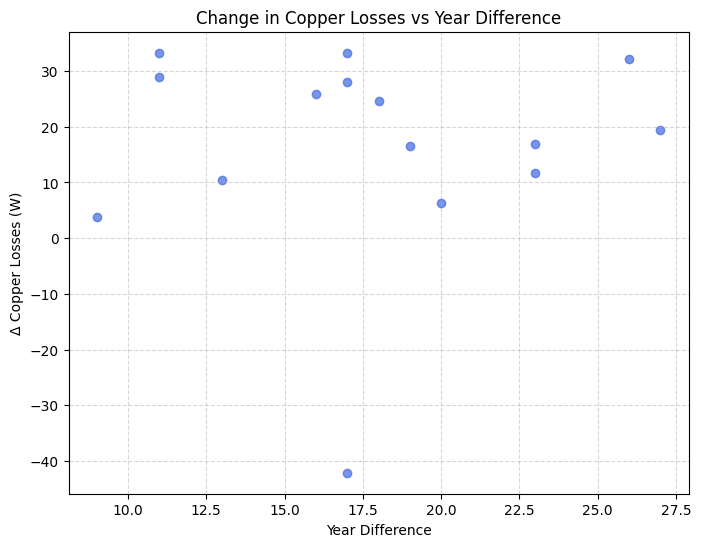

In [132]:
plt.figure(figsize=(8,6))
plt.scatter(diff_df['year_diff'], diff_df['heatRunTest_deltaTopOil'], color='royalblue', alpha=0.7)

plt.xlabel("Year Difference")
plt.ylabel("Δ Copper Losses (W)")
plt.title("Change in Copper Losses vs Year Difference")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

This looks like nonsense when compared to the experimental results

| Parameter                                | Physical meaning                            | Possible time-dependent effect                                          | Likely trend with age          |
| ---------------------------------------- | ------------------------------------------- | ----------------------------------------------------------------------- | ------------------------------ |
| **s** (stray-loss fraction)              | Fraction of load losses in structural parts | Winding displacement, mechanical loosening → altered leakage flux paths | ↑ (slight increase)            |
| **pf** (effective load power factor)     | Typical operating load PF                   | Customer mix changes (industrial → residential, renewables, EVs)        | Variable (↑ or ↓)              |
| **ambient\_bias**                        | Sensor/systematic offset                    | Sensor drift, probe replacement, fouling causing localized heating      | Unpredictable (±), often drift |
| **ΔTopOil (heatRunTest\_deltaTopOil)**   | Oil rise at rated load                      | Oil oxidation, sludge formation, fan/pump wear                          | ↑ (higher rises)               |
| **ΔHotspot (heatRunTest\_deltaHotspot)** | Hotspot rise at rated load                  | Insulation embrittlement, reduced heat transfer to oil                  | ↑ (higher rises)               |
| **x** (oil exponent)                     | Nonlinearity of oil heating curve           | Oil viscosity increase, convection impairment                           | ↑ (slightly higher)            |
| **y** (winding exponent)                 | Nonlinearity of winding heating curve       | Blocked ducts, uneven cooling, sludge                                   | ↑ (slightly higher)            |
| **h** (hotspot factor)                   | Ratio hotspot/top-oil                       | Localized hot-spots worsen as insulation/cooling paths degrade          | ↑                              |
| **Copper losses (Pcu\_ref\_W)**          | I²R losses in windings                      | Conductor oxidation, joints resistance increase, deformation            | ↑                              |
| **No-load losses (P0\_W)**               | Core losses at rated voltage                | Lamination insulation breakdown → higher eddy currents                  | ↑ (rare, but serious)          |
| **Nominal load (S\_rated)**              | Rated kVA capacity                          | Effective derating in practice due to aging cooling/insulation          | ↓ (derated capacity)           |


## What's next

1. Analise fitting just one variable at a time and try to find correlation to years in use
2. Distinguish between global (one analysis fits all transformers) and individual
    - Maybe individual makes more sense. i could check whether parameter fit on a nearby timeframe translates into accuracy in other timeframes (e.g. fitting parameters for a whole year since the start of the data and then checking on the remaining data how good performance is)
3. Now that it is clear that this variables have changed over time, then find which ones contribute the most to the final performance (choose rmse or mae, prob the one that is the least sensible to outliers given the data is not perfect and having outliers doesnt necessarily mean the model is wrong)
4. Read about limitations of the least_squares function
5. IDEA: Given that now I am extending on the model, then maybe I could add a term like *g · T_pred(t-1)* so last predicted temperature. This way we could add some temporal dynamic to the model, as the past temperature would have some effect on the T prediction. We could even go as far as to add a cooling term to make temporal gradients in T follow difussion formulas. this would make the model heavy, but pinns are good at dealing with this, and AD would assist with the computation during training.
6. I also need to decide on the potential training protocol
    - Fixed window of 10 days or smth?
    - Full year window? too heavy imo
    - One day window?
    - The thing is given that the load contains very similar fft harmonics as the hotspot temperature, and the load is one of the input variables, then probably the window length is not that important and we could literally predict step by step.
7. Idea for benchmarking. Comparing how good this model is at predicting the T vs how good models are at predicting future load, because in a real usecase the model would be used with the predicted load. Dataset for load prediction available at elia open data.

### Variables
(First draft)

**Input**
- Load(t)
- T_ambient(t)
- T_pred(t-1)

**Output**
- T_pred(t)

During training I should probably use T_gt(t-1) instead of T_pred during a number of epochs

### 1. Do this same analysis with just one variable at a time and try to find correlation to years in use

#### Fixing init_override

In [ ]:
# --------------------------------------------------------------------
# 1. Define registry of all possible parameters
# --------------------------------------------------------------------
PARAMS_REGISTRY = {
    's':                        {'default': 0.0, 'bounds': (0.00, 0.25)},
    'pf':                       {'default': 1, 'bounds': (0.80, 1.00)},
    'ambient_bias':             {'default': 0.0,  'bounds': (-10.0, 10.0)},
    'heatRunTest_deltaTopOil':  {'default': 50.0, 'bounds': (5.0, 80.0)},
    'heatRunTest_deltaHotspot': {'default': 63.0, 'bounds': (10.0, 120.0)},
    'heatRunTest_x':            {'default': 0.8,  'bounds': (0.5, 1.2)},
    'heatRunTest_y':            {'default': 1.5,  'bounds': (0.8, 2.2)},
    'heatRunTest_h':            {'default': 1.0,  'bounds': (0.7, 1.5)},
    'heatRunTest_copperLosses': {'default': None, 'bounds': (1, 1e6)},
    'heatRunTest_noLoadLosses': {'default': None, 'bounds': (1, 1e6)},
    'nominalLoad':              {'default': None, 'bounds': (1.0, 1e6)},
    'kFactor':                 {'default': 1.0, 'bounds': (0.1, 10.0)},
}

ALL_PARAM_KEYS = list(PARAMS_REGISTRY.keys())

RENAME_MAP = {
        'deltaTopOil':     'heatRunTest_deltaTopOil',
        'deltaHotspot':    'heatRunTest_deltaHotspot',
        'x':               'heatRunTest_x',
        'y':               'heatRunTest_y',
        'h':               'heatRunTest_h',
        'noLoadLosses':    'heatRunTest_noLoadLosses',
        'copperLosses':    'heatRunTest_copperLosses',
        'nominalLoad':     'nominalLoad',
        'pf':              'pf',
        's':               's',
        'ambient_bias':    'ambient_bias',
    }

# --------------------------------------------------------------------
# 2. Helper to load per-equipment defaults from tfo_parameters.csv
# --------------------------------------------------------------------
def load_base_params_by_eid(TFO_PARAMETERS_FILE):
    tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
    tfo_parameters.rename(columns=RENAME_MAP, inplace=True)

    base_params_by_eid = {}
    for _, r in tfo_parameters.iterrows():
        eid = r['equipmentId']
        d = {}
        for k in ALL_PARAM_KEYS:
            if k in r and pd.notna(r[k]):
                d[k] = float(r[k])
        base_params_by_eid[eid] = d
    return base_params_by_eid

def materialize_params(p_hat, base_params):
    """Build a full {param: value} covering ALL_PARAM_KEYS using:
       1) fitted values (p_hat), then 2) base_params (tfo), then 3) registry default."""
    out = {}
    for k in ALL_PARAM_KEYS:
        if k in p_hat:
            out[k] = float(p_hat[k])
        elif base_params and k in base_params:
            out[k] = float(base_params[k])
        else:
            out[k] = PARAMS_REGISTRY[k]['default']
    return out

# --------------------------------------------------------------------
# 3. Build x0 and bounds for least squares
# --------------------------------------------------------------------
def build_x0_bounds(selected_keys, base_params=None, init_overrides=None, bounds_overrides=None):
    x0, lb, ub = [], [], []
    for k in selected_keys:
        b_l, b_u = PARAMS_REGISTRY[k]['bounds']
        if bounds_overrides and k in bounds_overrides:
            b_l, b_u = bounds_overrides[k]

        if init_overrides and k in init_overrides:
            val = init_overrides[k]
        elif base_params and k in base_params:
            val = base_params[k]
        else:
            val = PARAMS_REGISTRY[k]['default']
            if val is None:
                val = (b_l + b_u) / 2.0

        x0.append(float(val))
        lb.append(float(b_l))
        ub.append(float(b_u))
    return np.array(x0), np.array(lb), np.array(ub)

# --------------------------------------------------------------------
# 4. Prediction model
# --------------------------------------------------------------------
def _get_series_or_param(d, params, param_key, df_col):
    if param_key in params:
        return np.full(len(d), float(params[param_key]), dtype=float)
    return d[df_col].to_numpy(dtype=float)

def wb_predict(d, params):
    s   = params.get('s', PARAMS_REGISTRY['s']['default'])
    pf  = params.get('pf', PARAMS_REGISTRY['pf']['default'])
    amb_bias = params.get('ambient_bias', PARAMS_REGISTRY['ambient_bias']['default'])

    dTO = params.get('heatRunTest_deltaTopOil', PARAMS_REGISTRY['heatRunTest_deltaTopOil']['default'])
    dH  = params.get('heatRunTest_deltaHotspot', PARAMS_REGISTRY['heatRunTest_deltaHotspot']['default'])
    x   = params.get('heatRunTest_x', PARAMS_REGISTRY['heatRunTest_x']['default'])
    y   = params.get('heatRunTest_y', PARAMS_REGISTRY['heatRunTest_y']['default'])
    h   = params.get('heatRunTest_h', PARAMS_REGISTRY['heatRunTest_h']['default'])

    Pcu_ref_W = _get_series_or_param(d, params, 'heatRunTest_copperLosses', 'heatRunTest_copperLosses')
    P0_W      = _get_series_or_param(d, params, 'heatRunTest_noLoadLosses', 'heatRunTest_noLoadLosses')
    S_namepl  = _get_series_or_param(d, params, 'nominalLoad', 'nominalLoad')

    Pload_ref = Pcu_ref_W / (1.0 - s)
    R = Pload_ref / P0_W

    P_kW = d['load'].to_numpy(dtype=float)
    S_base = S_namepl * 1000.0  # MVA → kVA (old behavior)
    K = np.clip(P_kW / (pf * S_base), 0.0, 2.5)

    top_oil_rise = dTO * np.power((1.0 + R * (K**2)) / (1.0 + R), x)
    hs_rise      = h * (K**y) * (dH - dTO)

    return d['temperature'].to_numpy(dtype=float) + amb_bias + top_oil_rise + hs_rise

# --------------------------------------------------------------------
# 5. Residuals and metrics
# --------------------------------------------------------------------
def residuals_vec(theta, d, selected_keys, model = wb_predict(), base_params=None, priors=None, prior_weight=0.0):
    fitted = {k: float(v) for k, v in zip(selected_keys, theta)}
    merged = {**(base_params or {}), **fitted}
    pred = model(d, merged)
    res  = pred - d['hotspotTemperature'].to_numpy(dtype=float)
    if priors and prior_weight > 0:
        reg = []
        for k, mu in priors.items():
            if k in fitted:
                reg.append(prior_weight * (fitted[k] - mu))
        if reg:
            res = np.concatenate([res, np.array(reg, dtype=float)])
    return res

def get_preds_and_metrics(d, params_hat, model=wb_predict(), base_params=None, load_col='load', nominal_load_col='nominalLoad'):
    merged = {**(base_params or {}), **params_hat}
    pred = model(d, merged)
    tgt  = d['hotspotTemperature'].to_numpy(dtype=float)
    metrics_dict = get_metrics(d, tgt, pred, load_col=load_col, nominal_load_col=nominal_load_col)
    return metrics_dict, pred

# --------------------------------------------------------------------
# 6. Fit one transformer
# --------------------------------------------------------------------
def fit_transformer(df_equipment,
                    selected_keys,
                    model=wb_predict(),
                    base_params=None,
                    init_overrides=None,
                    bounds_overrides=None,
                    priors=None,
                    prior_weight=0.0):

    needed = ['temperature','hotspotTemperature','load','nominalLoad',
              'heatRunTest_copperLosses','heatRunTest_noLoadLosses']
    d = df_equipment[needed].dropna().copy()
    if d.empty:
        raise ValueError("No valid rows after dropna.")

    x0, lb, ub = build_x0_bounds(selected_keys, base_params, init_overrides, bounds_overrides)
    sol = least_squares(residuals_vec, x0,
                        args=(d, selected_keys, model, base_params, priors, prior_weight),
                        bounds=(lb, ub), loss='soft_l1', f_scale=5.0, max_nfev=500)

    params_hat = {k: float(v) for k, v in zip(selected_keys, sol.x)}
    metrics, pred = get_preds_and_metrics(d, params_hat, model=model, base_params=base_params)
    return params_hat, metrics, pred

# --------------------------------------------------------------------
# 7. Fit all transformers
# --------------------------------------------------------------------

def materialize_params(p_hat, base_params, all_keys=ALL_PARAM_KEYS):
    # fitted → base → registry default
    out = {}
    for k in all_keys:
        if k in p_hat:
            out[k] = float(p_hat[k])
        elif base_params and (k in base_params):
            out[k] = float(base_params[k])
        else:
            out[k] = PARAMS_REGISTRY[k]['default']
    return out

def fit_all_transformers(df, id_col='equipmentId',
                         selected_keys=None,
                         base_params_by_eid=None,
                         model=wb_predict(),
                         init_overrides_by_eid=None,
                         bounds_overrides=None,
                         priors=None, prior_weight=0.0,
                         og_comparison=False,
                         savefile=None, print_metrics=False):

    if selected_keys is None:
        selected_keys = ['s','pf','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot',
                         'heatRunTest_x','heatRunTest_y','heatRunTest_h']

    results, preds = [], []

    for eid, g in df.groupby(id_col):
        try:
            base_params = (base_params_by_eid or {}).get(eid, {})
            init_over   = (init_overrides_by_eid or {}).get(eid, None)

            # -------- FITTED RUN --------
            p_hat, metrics_fit, pred_fit = fit_transformer(
                g, selected_keys,
                base_params=base_params,
                model=model,
                init_overrides=init_over,
                bounds_overrides=bounds_overrides,
                priors=priors, prior_weight=prior_weight
            )

            params_out_fit = materialize_params(p_hat, base_params)
            year_fit = 2024

            # Collect preds (long, with source)
            tmp_fit = g[['dateTime', id_col, 'hotspotTemperature']].copy()
            tmp_fit['wb_pred'] = pred_fit
            tmp_fit['source'] = 'fit'
            preds.append(tmp_fit)

            # -------- OG (TFO) COMPARISON --------
            params_out_og = {k: np.nan for k in ALL_PARAM_KEYS}
            metrics_og = {k: np.nan for k in METRIC_COLUMNS}
            year_og = np.nan

            if og_comparison:
                # Take OG params for selected keys from base_params (no optimization)
                og_params = {k: float(base_params[k]) for k in selected_keys if k in base_params}
                metrics_og, pred_og = get_preds_and_metrics(g, og_params, base_params=base_params)
                params_out_og = materialize_params(og_params, base_params)
                # pick an OG year if present
                if 'manufactureYear' in g.columns and g['manufactureYear'].notna().any():
                    year_og = g['manufactureYear'].dropna().iloc[0]

                # preds for OG
                tmp_og = g[['dateTime', id_col, 'hotspotTemperature']].copy()
                tmp_og['wb_pred'] = pred_og
                tmp_og['source'] = 'og'
                preds.append(tmp_og)

            # -------- BUILD ONE WIDE ROW --------
            wide_row = {
                'equipmentId': eid,
                'year_fit': year_fit,
                'year_og': year_og,
                'year_diff': (year_fit - year_og) if pd.notna(year_og) else np.nan,
                'n': int(len(g)),
            }

            # suffix all params + metrics
            for k, v in params_out_fit.items():
                wide_row[f'{k}_fit'] = v
            for k, v in metrics_fit.items():
                wide_row[f'{k}_fit'] = v

            for k, v in params_out_og.items():
                wide_row[f'{k}_og'] = v
            for k, v in metrics_og.items():
                wide_row[f'{k}_og'] = v

            results.append(wide_row)

        except Exception as e:
            results.append({'equipmentId': eid, 'error': str(e)})

    res_df = pd.DataFrame(results)
    pred_df = pd.concat(preds, ignore_index=True) if preds else None

    if savefile:
        res_df.to_csv(f"wb_{savefile}_parameters.csv", index=False)
        if pred_df is not None:
            pred_df.to_csv(f"wb_{savefile}_fitted.csv", index=False)

    if print_metrics and not res_df.empty:
        # Average only FIT metrics in the wide table
        fit_metric_cols = [c for c in [f'{metric_col}_fit' for metric_col in METRIC_COLUMNS] if c in res_df.columns]
        if fit_metric_cols:
            print_metrics_cols(res_df, fit_metric_cols)

    return res_df, pred_df

# --------------------------------------------------------------------
# 8. Example usage
# --------------------------------------------------------------------
# Load per-transformer defaults
# base_params_by_eid = load_base_params_by_eid(TFO_PARAMETERS_FILE)

# # Choose which params to fit
# selected_keys = ['s','pf','ambient_bias',
#                  'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot',
#                  'heatRunTest_x','heatRunTest_y','heatRunTest_h']

# # Run batch fitting
# fit_table, pred_df = fit_all_transformers(
#     alldf, id_col='equipmentId',
#     selected_keys=selected_keys,
#     base_params_by_eid=base_params_by_eid,
#     prior_weight=0.1,
#     savefile="run1",
#     print_metrics=False
# )

# # Sort results by RMSE
# fit_table = fit_table.sort_values(by="RMSE")
# print(fit_table.head())


In [126]:
keys = [
    's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

base_params_by_eid = load_base_params_by_eid(TFO_PARAMETERS_FILE)

all_tables = pd.DataFrame()
og_comparison = True
for key in keys:
    selected_keys = [
        key
    ]
    # init_overrides = tfo_parameters.set_index('equipmentId').to_dict(orient='index')
    fit_table, pred_df = fit_all_transformers(
        alldf, id_col='equipmentId',
        selected_keys=selected_keys,
        base_params_by_eid=base_params_by_eid,
        prior_weight=0.1,
        # savefile="run1",
        og_comparison = True,
        print_metrics=True
    )
    # og_comparison = False # So og entries are registered only once
    all_tables = pd.concat([all_tables, fit_table])
    # break

all_tables

MAE_fit: 7.296
RMSE_fit: 8.322
Bias_fit: -6.790
R2_fit: -0.912
NRMSE%_IQR_fit: 102.672
P95_abs_err_fit: 13.914
Max_abs_err_fit: 34.544
                    n       MAE      RMSE      Bias
K_bin                                              
<0.5     12227.933333  7.531382  8.490909 -7.115095
0.5–0.9   1544.866667  6.480426  7.711744 -2.612247
0.9–1.1     27.133333  6.756114  7.693838 -6.310424
>1.1         0.000000       NaN       NaN       NaN
MAE_fit: 5.527
RMSE_fit: 6.685
Bias_fit: -3.788
R2_fit: -0.206
NRMSE%_IQR_fit: 83.015
P95_abs_err_fit: 11.939
Max_abs_err_fit: 37.169
                    n        MAE       RMSE       Bias
K_bin                                                 
<0.5     12227.933333   5.553425   6.653075  -4.501723
0.5–0.9   1544.866667   7.280122   8.471357   5.954192
0.9–1.1     27.133333  12.505760  13.260654  12.482597
>1.1         0.000000        NaN        NaN        NaN
MAE_fit: 3.381
RMSE_fit: 4.467
Bias_fit: -0.410
R2_fit: 0.472
NRMSE%_IQR_fit: 54.838
P95_

,equipmentId,year_fit,year_og,year_diff,n,s_fit,pf_fit,ambient_bias_fit,heatRunTest_deltaTopOil_fit,heatRunTest_deltaHotspot_fit,...,K_0.5–0.9_RMSE_og,K_0.5–0.9_Bias_og,K_0.9–1.1_n_og,K_0.9–1.1_MAE_og,K_0.9–1.1_RMSE_og,K_0.9–1.1_Bias_og,K_>1.1_n_og,K_>1.1_MAE_og,K_>1.1_RMSE_og,K_>1.1_Bias_og
0,24917,2024,1997,27,14664,1.409274e-20,1.0,0.0,54.8,72.0,...,6.703824,3.333371,0,NaN,NaN,NaN,0,NaN,NaN,NaN
1,33291,2024,1998,26,14664,3.778600e-21,1.0,0.0,47.9,65.4,...,6.134129,0.737579,0,NaN,NaN,NaN,0,NaN,NaN,NaN
2,5004597,2024,2001,23,14664,2.657593e-20,1.0,0.0,48.9,65.7,...,8.027958,6.770986,0,NaN,NaN,NaN,0,NaN,NaN,NaN
3,5004625,2024,2001,23,14664,2.461954e-20,1.0,0.0,48.9,65.7,...,9.924175,7.815106,0,NaN,NaN,NaN,0,NaN,NaN,NaN
4,5017843,2024,2005,19,14664,3.537076e-21,1.0,0.0,45.4,60.8,...,4.736742,-4.049184,0,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,50033827,2024,2008,16,14664,0.000000e+00,1.0,0.0,54.1,67.4,...,8.897066,-7.665070,0,NaN,NaN,NaN,0,NaN,NaN,NaN
11,50249457,2024,2011,13,14664,0.000000e+00,1.0,0.0,51.9,67.7,...,6.100039,-4.554700,0,NaN,NaN,NaN,0,NaN,NaN,NaN
12,50250035,2024,2013,11,14664,0.000000e+00,1.0,0.0,51.0,70.0,...,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
13,50277055,2024,2013,11,14664,0.000000e+00,1.0,0.0,46.8,62.8,...,11.109689,-9.307056,172,6.16563,6.800157,-5.850788,0,NaN,NaN,NaN


In [4]:
def compute_differences_vs_og(df_wide, relative=True, keep_years=False):
    """
    Takes the wide table produced by fit_all_transformers (one row per equipmentId)
    and returns only the *_diff columns (fit - og).
    
    Parameters
    ----------
    df_wide : pd.DataFrame
        Wide table with *_fit and *_og columns.
    keep_years : bool
        If True, keep year_fit, year_og, year_diff for reference.
    """
    diffs = pd.DataFrame()
    diffs['equipmentId'] = df_wide['equipmentId']


    # collect only *_diff
    fit_cols = [c for c in df_wide.columns if c.endswith('_fit')]
    for c_fit in fit_cols:
        base = c_fit[:-4]
        c_og = base + '_og'
        if c_og in df_wide.columns:
            if pd.api.types.is_numeric_dtype(df_wide[c_fit]) and pd.api.types.is_numeric_dtype(df_wide[c_og]):
                if relative:
                    # relative diff
                    diffs[base + '_diff'] = (df_wide[c_fit] - df_wide[c_og]) / df_wide[c_og].replace(0, np.nan)
                else:
                    # absolute diff
                    diffs[base + '_diff'] = df_wide[c_fit] - df_wide[c_og]

    if 'year_fit' in df_wide and 'year_og' in df_wide:
        diffs['year_diff'] = df_wide['year_fit'] - df_wide['year_og']
        if keep_years:
            diffs['year_fit'] = df_wide['year_fit']
            diffs['year_og']  = df_wide['year_og']

    return diffs


In [17]:

def plot_differences(diffs, column, title=None, force_zero_intercept=False):
    """
    Scatter plot of year_diff (x) vs. a difference column (y),
    labeling each point by equipmentId. Skips rows where the
    column is 0 or NaN. Adds a linear fit and R^2 to the figure.
    
    Parameters
    ----------
    diffs : pd.DataFrame
        Differences table from compute_differences_vs_og
    column : str
        The difference column to plot (e.g. 'RMSE_diff')
    title : str, optional
        Plot title
    force_zero_intercept : bool, default False
        If True, fit line is forced through the origin (y = m*x).
    """
    if column not in diffs.columns:
        raise ValueError(f"{column} not in DataFrame")

    df_plot = diffs.copy()
    df_plot = df_plot[df_plot[column].notna() & (df_plot[column] != 0)]

    if df_plot.empty:
        print(f"No non-zero values to plot for column '{column}'.")
        return

    x = df_plot['year_diff'].to_numpy(dtype=float)
    y = df_plot[column].to_numpy(dtype=float)

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y)

    # Add labels for each point
    for _, row in df_plot.iterrows():
        plt.text(float(row['year_diff']), float(row[column]), str(row['equipmentId']),
                 fontsize=8, ha='right', va='bottom')

    r2_text = "R²: n/a"
    if len(x) >= 2 and np.nanstd(x) > 0:
        if force_zero_intercept:
            # Solve least squares for slope only
            m = np.sum(x * y) / np.sum(x * x)
            b = 0.0
        else:
            m, b = np.polyfit(x, y, 1)

        xs = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        ys = m * xs + b
        plt.plot(xs, ys, linewidth=1.5)

        # Compute R²
        y_hat = m * x + b
        ss_res = np.sum((y - y_hat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

        if force_zero_intercept:
            eq = f"y = {m:.3g}·x"
        else:
            eq = f"y = {m:.3g}·x + {b:.3g}"
        r2_text = f"{eq}\nR² = {r2:.3f}" if np.isfinite(r2) else f"{eq}\nR²: n/a"

    plt.axhline(0, linestyle='--', linewidth=0.8)
    plt.xlabel("Year Difference")
    plt.ylabel(column)
    plt.title(title if title else f"Year Difference vs {column}")
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.gca().text(0.02, 0.98, r2_text, transform=plt.gca().transAxes,
                   fontsize=9, va='top', ha='left',
                   bbox=dict(boxstyle='round,pad=0.3', alpha=0.1))

    plt.tight_layout()
    plt.show()
    
def show_metric_diff(diff_df, metric="RMSE", tol=1e-4, verbose=True, known_params=None):
    """
    Print and summarize how a chosen metric changed vs OG, grouped by the combination
    of variables that were adjusted (|param_diff| >= tol).

    Parameters
    ----------
    diff_df : pd.DataFrame
        Output from compute_differences_vs_og(...) – must contain:
        - 'equipmentId'
        - 'year_diff' (optional but useful)
        - '{metric}_diff' column for the chosen metric
        - parameter diff columns like 's_diff', 'pf_diff', 'heatRunTest_x_diff', etc.
    metric : str
        Metric name, e.g., 'RMSE', 'MAE', 'Bias', 'R2'.
    tol : float
        Absolute tolerance to decide if a variable is considered "adjusted".
        Variables with |diff| >= tol are treated as adjusted.
    verbose : bool
        If True, prints a line per equipmentId.
    known_params : list[str] or None
        If provided, only consider these names (without the '_diff' suffix) as parameters.
        If None, all *_diff columns except the chosen metric and year_diff are treated as params.

    Returns
    -------
    details_df : pd.DataFrame
        Columns: equipmentId, year_diff (if present), metric_diff, adjusted_vars
    summary_df : pd.DataFrame
        Grouped by adjusted_vars with mean_metric_diff, std_metric_diff, count
    """
    import pandas as pd
    import numpy as np

    metric_col = f"{metric}_diff"
    if metric_col not in diff_df.columns:
        raise ValueError(f"Column '{metric_col}' not found in diff_df.")

    # Identify parameter diff columns
    if known_params is not None:
        param_diff_cols = [f"{p}_diff" for p in known_params if f"{p}_diff" in diff_df.columns]
    else:
        # take all *_diff except the chosen metric and year_diff
        param_diff_cols = [
            c for c in diff_df.columns
            if c.endswith("_diff") and c not in {metric_col, "year_diff"}
        ]

    # Build details rows
    records = []
    for _, row in diff_df.iterrows():
        # which params are "adjusted"?
        adjusted = []
        for c in param_diff_cols:
            val = row[c]
            if pd.notna(val) and abs(val) >= tol:
                adjusted.append(c[:-5])  # strip '_diff' suffix

        adjusted_vars = ",".join(sorted(adjusted)) if adjusted else "(none)"
        rec = {
            "equipmentId": row["equipmentId"],
            "metric_diff": row[metric_col],
            "adjusted_vars": adjusted_vars
        }
        if "year_diff" in diff_df.columns:
            rec["year_diff"] = row["year_diff"]
        records.append(rec)

        if verbose:
            yd_txt = f", Δyears={int(row['year_diff'])}" if "year_diff" in rec and pd.notna(rec["year_diff"]) else ""
            print(f"{row['equipmentId']}: Δ{metric}={row[metric_col]:.4f}{yd_txt} | adjusted: {adjusted_vars}")

    details_df = pd.DataFrame(records)

    # Summary by combination
    agg_dict = {"metric_diff": ["mean", "std", "count"]}
    summary = (
        details_df.groupby("adjusted_vars", dropna=False)["metric_diff"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"mean": "mean_metric_diff", "std": "std_metric_diff", "count": "count"})
        .sort_values(["count", "mean_metric_diff"], ascending=[False, True])
        .reset_index(drop=True)
    )

    return details_df, summary


In [20]:
diff_df = compute_differences_vs_og(all_tables, relative=True)
diff_df

,equipmentId,year_diff,s_diff,pf_diff,ambient_bias_diff,heatRunTest_deltaTopOil_diff,heatRunTest_deltaHotspot_diff,heatRunTest_x_diff,heatRunTest_y_diff,heatRunTest_h_diff,heatRunTest_copperLosses_diff,heatRunTest_noLoadLosses_diff,nominalLoad_diff,MAE_diff,RMSE_diff,Bias_diff,R2_diff
0,24917,27,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
1,33291,26,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,-0.000000
2,5004597,23,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
3,5004625,23,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
4,5017843,19,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,50033827,16,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.254073,-0.385914,-0.332610,-0.714154,-0.760392
11,50249457,13,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.182130,-0.264428,-0.244080,-0.689343,-1.756714
12,50250035,11,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.390791,-0.294109,-0.211968,-0.462801,-0.589279
13,50277055,11,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.180497,-0.401295,-0.355806,-0.813446,-1.059956


No non-zero values to plot for column 's_diff'.


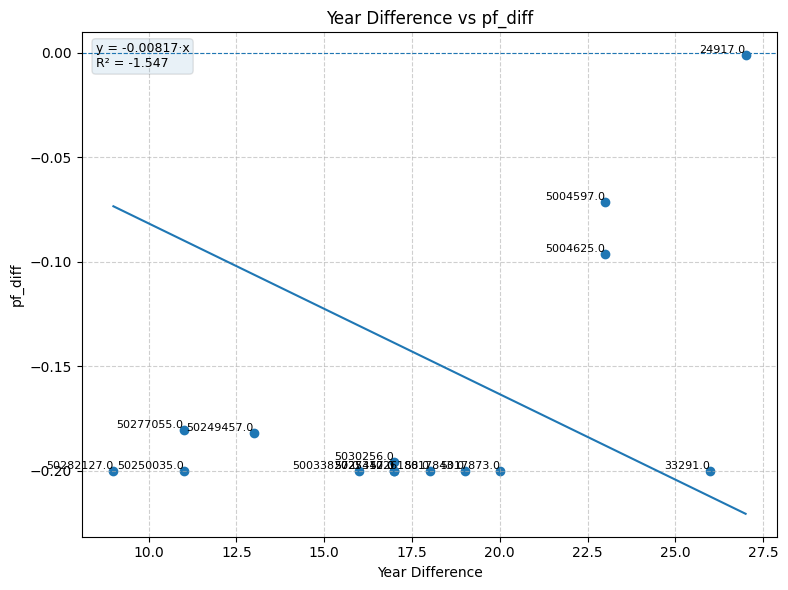

No non-zero values to plot for column 'ambient_bias_diff'.


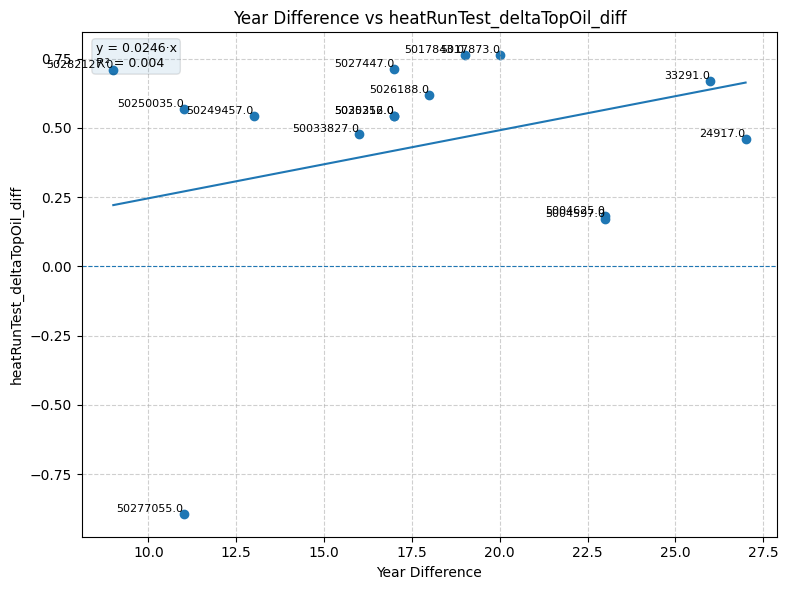

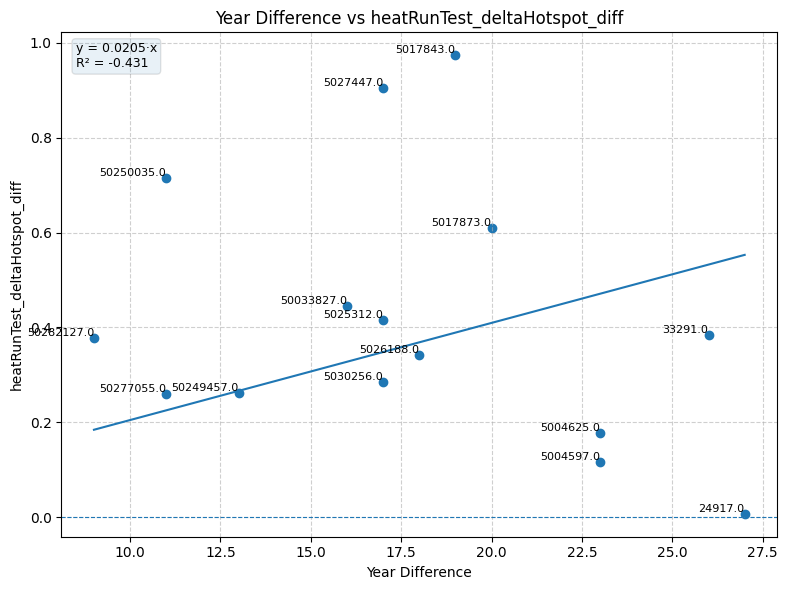

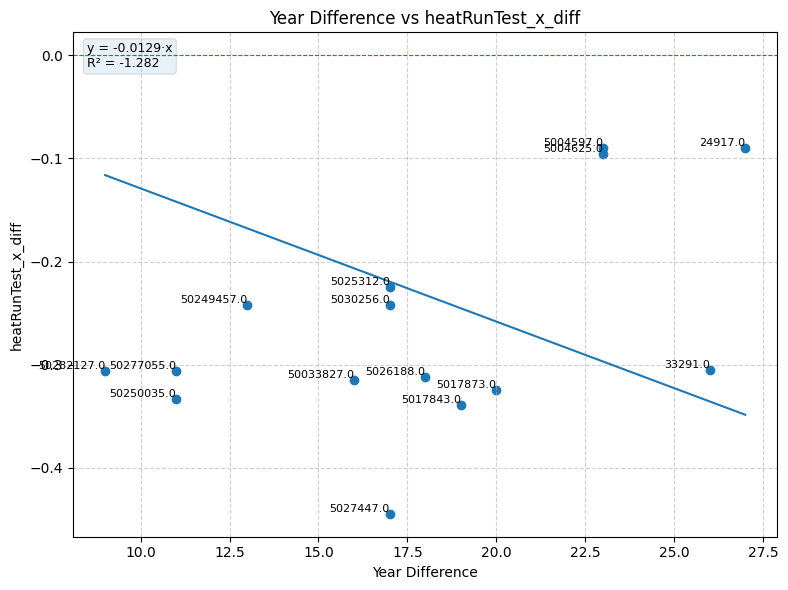

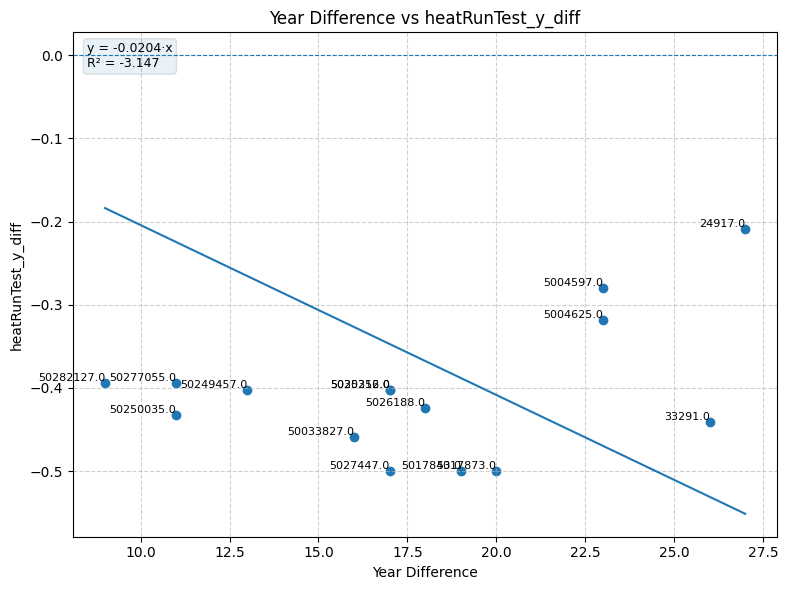

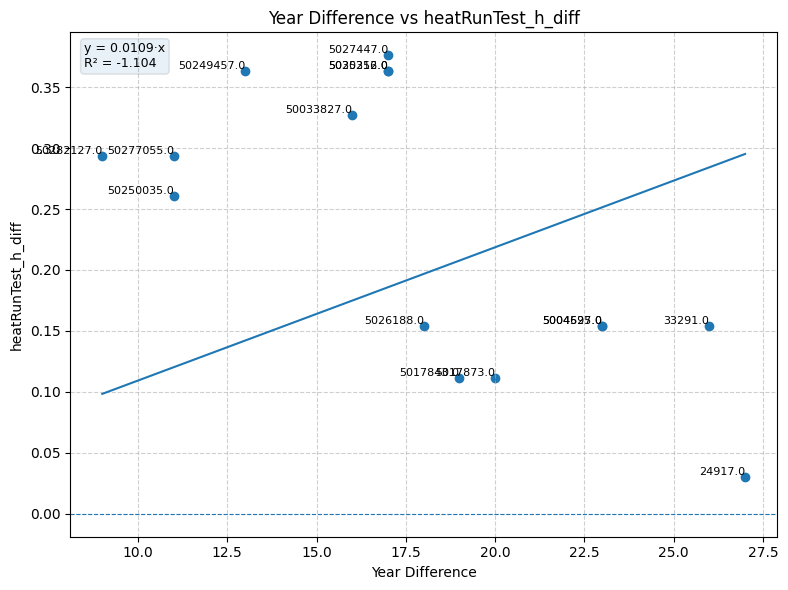

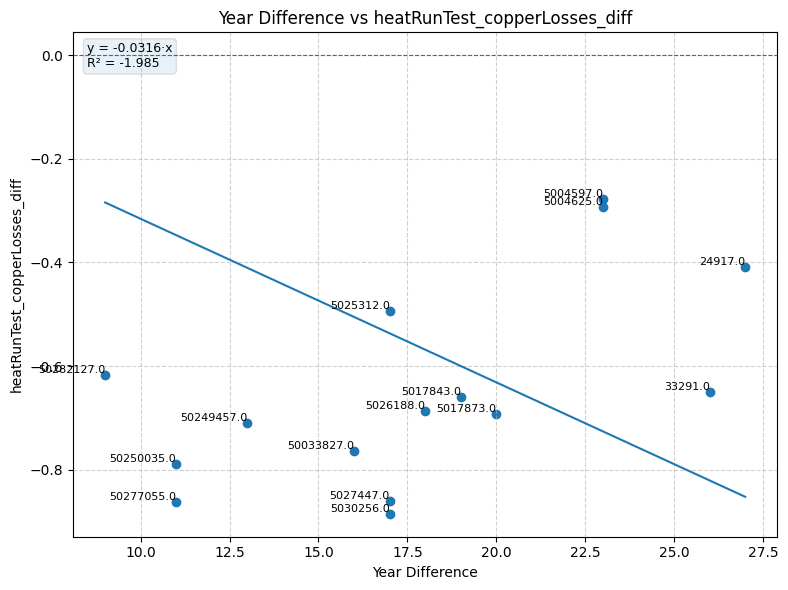

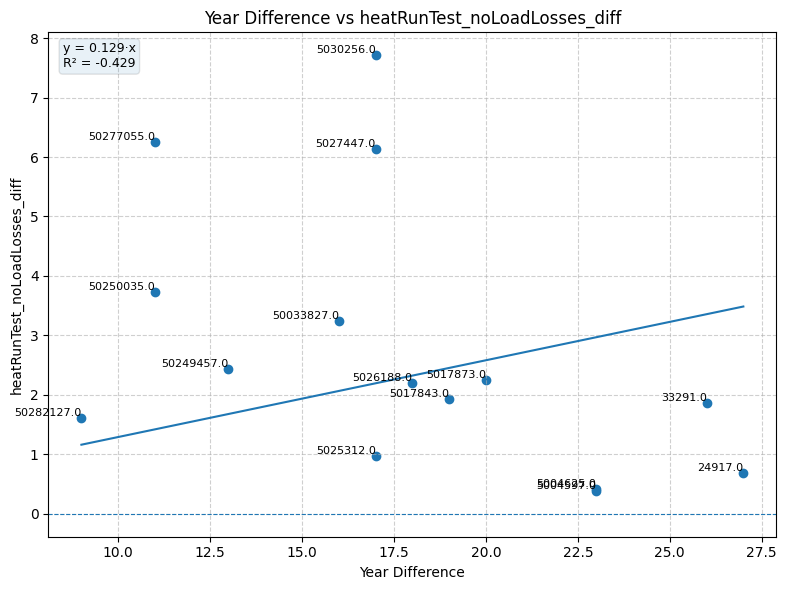

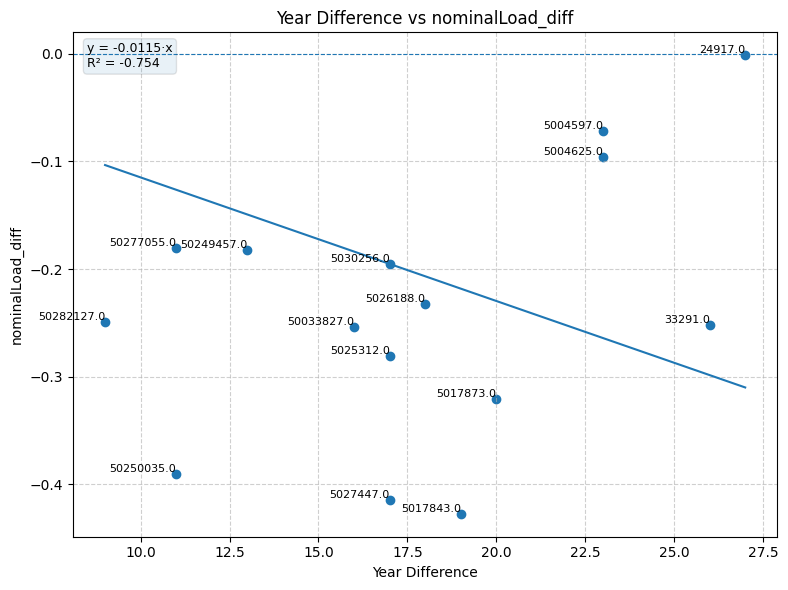

In [21]:
for key in keys:
    plot_differences(diff_df, f"{key}_diff", force_zero_intercept=True)

In [70]:
details, summary = show_metric_diff(diff_df, metric="MAE", tol=1e-4, verbose=True, known_params=keys)

24917.0: ΔMAE=0.0000, Δyears=27 | adjusted: (none)
33291.0: ΔMAE=0.0000, Δyears=26 | adjusted: (none)
5004597.0: ΔMAE=0.0000, Δyears=23 | adjusted: (none)
5004625.0: ΔMAE=0.0000, Δyears=23 | adjusted: (none)
5017843.0: ΔMAE=0.0000, Δyears=19 | adjusted: (none)
5017873.0: ΔMAE=0.0000, Δyears=20 | adjusted: (none)
5025312.0: ΔMAE=0.0000, Δyears=17 | adjusted: (none)
5026188.0: ΔMAE=0.0000, Δyears=18 | adjusted: (none)
5027447.0: ΔMAE=0.0000, Δyears=17 | adjusted: (none)
5030256.0: ΔMAE=0.0000, Δyears=17 | adjusted: (none)
50033827.0: ΔMAE=0.0000, Δyears=16 | adjusted: (none)
50249457.0: ΔMAE=0.0000, Δyears=13 | adjusted: (none)
50250035.0: ΔMAE=0.0000, Δyears=11 | adjusted: (none)
50277055.0: ΔMAE=0.0000, Δyears=11 | adjusted: (none)
50282127.0: ΔMAE=0.0000, Δyears=9 | adjusted: (none)
24917.0: ΔMAE=0.0001, Δyears=27 | adjusted: pf
33291.0: ΔMAE=-1.4307, Δyears=26 | adjusted: pf
5004597.0: ΔMAE=-0.0351, Δyears=23 | adjusted: pf
5004625.0: ΔMAE=-0.0557, Δyears=23 | adjusted: pf
5017843.0:

In [87]:
summary

,adjusted_vars,mean_metric_diff,std_metric_diff,count
0,heatRunTest_noLoadLosses,-4.062841,2.685954,15
1,heatRunTest_copperLosses,-4.062841,2.685954,15
2,ambient_bias,-3.914863,2.593999,15
3,heatRunTest_x,-3.424320,2.132426,15
4,heatRunTest_deltaHotspot,-2.262160,1.695907,15
5,nominalLoad,-2.146189,1.666610,15
6,heatRunTest_y,-2.000919,1.019727,15
7,pf,-1.768587,1.502839,15
8,heatRunTest_deltaTopOil,-1.324341,0.740651,15
9,heatRunTest_h,-0.684073,0.766249,15


In [43]:
all_tables[all_tables['equipmentId'] == 50249457]#[['heatRunTest_noLoadLosses_fit', 'heatRunTest_noLoadLosses_og']]

,equipmentId,year_fit,year_og,year_diff,n,s_fit,pf_fit,ambient_bias_fit,heatRunTest_deltaTopOil_fit,heatRunTest_deltaHotspot_fit,...,heatRunTest_y_og,heatRunTest_h_og,heatRunTest_copperLosses_og,heatRunTest_noLoadLosses_og,nominalLoad_og,MAE_og,RMSE_og,Bias_og,R2_og,error
11,50249457,2024.0,2011.0,13.0,14664.0,3.554822e-21,1.00000,0.0,51.9,67.700000,...,1.34,1.1,106.3,9.5,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,0.81787,0.0,51.9,67.700000,...,1.34,1.1,106.3,9.5,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,1.00000,5.0,51.9,67.700000,...,1.34,1.1,106.3,9.5,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,1.00000,0.0,80.0,67.700000,...,1.34,1.1,106.3,9.5,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,1.00000,0.0,51.9,85.355673,...,1.34,1.1,106.3,9.5,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,1.00000,0.0,51.9,67.700000,...,1.34,1.1,106.3,9.5,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,1.00000,0.0,51.9,67.700000,...,1.34,1.1,106.3,9.5,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,1.00000,0.0,51.9,67.700000,...,1.34,1.1,106.3,9.5,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,1.00000,0.0,51.9,67.700000,...,1.34,1.1,106.3,9.5,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
11,50249457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Initial guess is outside of provided bounds


In [121]:
selected_keys = [
    'ambient_bias','heatRunTest_x',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses'
]

base_params_by_eid = load_base_params_by_eid(TFO_PARAMETERS_FILE)

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    base_params_by_eid=base_params_by_eid,
    prior_weight=0.1,
    print_metrics=True,
    og_comparison=True
)

MAE_fit: 3.122
RMSE_fit: 4.187
Bias_fit: -0.091
R2_fit: 0.541
NRMSE%_IQR_fit: 51.318
P95_abs_err_fit: 8.315
Max_abs_err_fit: 32.400
                    n       MAE      RMSE      Bias
K_bin                                              
<0.5     12227.933333  3.123223  4.160882 -0.123339
0.5–0.9   1544.866667  4.132053  5.228732  0.363382
0.9–1.1     27.133333  3.410962  4.364910 -0.329378
>1.1         0.000000       NaN       NaN       NaN


In [120]:
selected_keys = [
    's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

base_params_by_eid = load_base_params_by_eid(TFO_PARAMETERS_FILE)

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    base_params_by_eid=base_params_by_eid,
    prior_weight=0.1,
    print_metrics=True
)

MAE_fit: 3.055
RMSE_fit: 4.085
Bias_fit: -0.117
R2_fit: 0.563
NRMSE%_IQR_fit: 50.012
P95_abs_err_fit: 7.970
Max_abs_err_fit: 32.742
                    n       MAE      RMSE      Bias
K_bin                                              
<0.5     12227.933333  3.042211  4.044700 -0.066595
0.5–0.9   1544.866667  4.030377  5.005013 -0.483913
0.9–1.1     27.133333  3.393514  4.382438  0.582330
>1.1         0.000000       NaN       NaN       NaN


In [130]:
selected_keys = [
    'heatRunTest_x',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses'
]

base_params_by_eid = load_base_params_by_eid(TFO_PARAMETERS_FILE)

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    base_params_by_eid=base_params_by_eid,
    prior_weight=0.1,
    print_metrics=True
)

MAE_fit: 3.165
RMSE_fit: 4.233
Bias_fit: -0.123
R2_fit: 0.531
NRMSE%_IQR_fit: 51.841
P95_abs_err_fit: 8.417
Max_abs_err_fit: 32.373
                    n       MAE      RMSE      Bias
K_bin                                              
<0.5     12227.933333  3.144267  4.180973 -0.052796
0.5–0.9   1544.866667  4.221143  5.382418  1.205936
0.9–1.1     27.133333  5.340270  6.398534 -4.564862
>1.1         0.000000       NaN       NaN       NaN


## Explore Bias Correction as Naive Model

Here I will explore the approach of just correcting the bias but for each transformer separately.

In [34]:
def get_bias_by_transformer(df, id_col='equipmentId', print_results=False):
    biasses = {}
    for eid, g in df.groupby(id_col):
        result = eval_wb(g)
        if print_results: 
            print(f"Evaluating equipmentId={eid} with {len(g)} rows")
            print(result)
        biasses[eid] = result['Bias']
    return biasses

def add_bias_to_df(df, bias_map, id_col='equipmentId'):
    df = df.copy()
    df['wb_bias'] = df[id_col].map(bias_map)
    df['bias_predicted'] = df['wb_pred'] - df['wb_bias']
    return df


In [134]:
biasses = get_bias_by_transformer(alldf, id_col='equipmentId')
alldf_bias = add_bias_to_df(alldf, biasses, id_col='equipmentId')
results = eval_wb(alldf_bias, y_pred='bias_predicted')
print_metrics_cols(results)

MAE: 3.258
RMSE: 4.484
Bias: 0.000
R2: 0.862
NRMSE%_IQR: 30.012
P95_abs_err: 9.058
Max_abs_err: 115.658
                n       MAE      RMSE      Bias
K_bin                                          
<0.5     183404.0  3.115890  4.289417 -0.275985
0.5–0.9   23173.0  4.714945  5.968430  1.772718
0.9–1.1     407.0  4.964332  6.256538  4.165185
>1.1          0.0       NaN       NaN       NaN
